In [1]:
import os
import sys
import time
from IPython.display import display
project_path = os.getcwd()
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, '9in_10out')
sys.path.insert(0, objective_path)

import numpy as np
import pandas as pd
import torch
from nextorch import plotting, bo, doe, utils, io, parameter

# CSV to DataFrame
input_data = pd.read_csv('compound_data')
# Selection of compounds and removal of SMILES column
input_data = input_data.iloc[:,1:]
# Conversion to Numpy array
input_data_array = input_data.to_numpy()

In [2]:
def run_experiment(n_init, n_trials):
    ##%% Initialize a multi-objective Experiment object
    # Set its name, the files will be saved under the folder with the same name
    Exp_9_10 = bo.EHVIMOOExperiment('mice_9_10_open')

    # Set the type and range for each parameter
    par_mw = parameter.Parameter(x_type = 'continuous', x_range=[20,1000])
    par_logP = parameter.Parameter(x_type = 'continuous', x_range=[-10,10])
    par_hbd = parameter.Parameter(x_type = 'ordinal', x_range=[0,15], interval=1)
    par_hba = parameter.Parameter(x_type = 'ordinal', x_range=[0,20], interval=1)
    par_tpsa = parameter.Parameter(x_type = 'continuous', x_range=[0,3000])
    par_mr = parameter.Parameter(x_type = 'continuous', x_range=[20,150])
    par_rb = parameter.Parameter(x_type = 'ordinal', x_range=[0,15], interval=1)
    par_ar = parameter.Parameter(x_type = 'ordinal', x_range=[0,10], interval=1)
    par_ha = parameter.Parameter(x_type = 'ordinal', x_range=[1,100], interval=1)

    parameters = [par_mw, par_logP, par_hbd, par_hba, par_tpsa, par_mr, par_rb, par_ar, par_ha]
    Exp_9_10.define_space(parameters)

    import biomarker_functions as bi

    # Choose whether to standardize output (using data from LHC sample)
    stand_flag = False

    if stand_flag:
        X_unit = doe.latin_hypercube(n_dim = 9, n_points = 500, seed = 1)
        X_real = utils.encode_to_real_ParameterSpace(X_unit, Exp_9_10.parameter_space)
        Y = bi.compute_biomarkers(X_real)
        bio_mean = pd.DataFrame(Y).mean().to_list()
        bio_std = pd.DataFrame(Y).std().to_list()
        objective_func = lambda X: (bi.compute_biomarkers(X) - bio_mean) / bio_std
    else:
        objective_func = bi.compute_biomarkers

    # Define the design space
    X_name_list = [
        "Molecular Weight",
        "LogP",
        "Hydrogen Bond Donors",
        "Hydrogen Bond Acceptors",
        "Topological Polar Surface Area",
        "Molar Refractivity",
        "Rotatable Bonds",
        "Aromatic Rings",
        "Heavy Atoms"
    ]

    Y_name_list = [
        "Inflammatory Response",
        "Oxidative Stress",
        "Neuroprotection",
        "Mitochondrial Function",
        "Synaptic Function",
        "Motor Function",
        "Cognitive Function",
        "Cardiac Function",
        "Liver Function",
        "Kidney Function"
    ]

    var_names = X_name_list + Y_name_list

    # Get the information of the design space
    n_dim = len(X_name_list) # the dimension of inputs
    n_objective = len(Y_name_list) # the dimension of outputs

    ##%% Initial Sampling
    # Latin hypercube design
    X_init = doe.latin_hypercube(n_dim = n_dim, n_points = n_init)
    # Get the initial responses
    Y_init = bo.eval_objective_func_encoding(X_init, Exp_9_10.parameter_space, objective_func)

    # Import the initial data
    Exp_9_10.input_data(X_init,
                       Y_init,
                       X_names = X_name_list,
                       Y_names = Y_name_list,
                       unit_flag = True,
                       standardized = stand_flag)

    # Set the optimization specifications
    if stand_flag:
        ref_point = [-3.0]*10
    else:
        ref_point = [5,5,3,0,0,0,1,3,1,0.5]

    Exp_9_10.set_ref_point(ref_point)
    Exp_9_10.set_optim_specs(objective_func = objective_func,
                            maximize = True)

    for i in range(n_trials):
        if i%20 == 0:
            print("{} trials completed".format(i))
        # Generate the next experiment point
        X_new, X_new_real, acq_func = Exp_9_10.generate_next_point(n_candidates=1)
        # Get the reponse at this point
        Y_new_real = objective_func(X_new_real)
        # Retrain the model by input the next point into Exp object
        Exp_9_10.run_trial(X_new, X_new_real, Y_new_real)
    
    # Results:
    from botorch.utils.multi_objective.hypervolume import Hypervolume
    sample_size = Exp_9_10.Y_real.shape[0]
    front_size = Exp_9_10.get_optim()[0].shape[0]
    final_hypervolume_obj = Hypervolume(torch.tensor(ref_point))
    final_hypervolume = final_hypervolume_obj.compute(torch.from_numpy(Exp_9_10.get_optim()[0]))
    return front_size/sample_size, final_hypervolume

In [3]:
argument_pairs = [[100,0], [40,60]]
iterations = 50
results = np.empty(shape=[len(argument_pairs), iterations, 2])

for i in range(len(argument_pairs)):
    for j in range(iterations):
        fs, fh = run_experiment(argument_pairs[i][0], argument_pairs[i][1])
        results[i,j] = [fs, fh]
        print(i,j)

/Users/jamessykes/Documents/Summer 2024/MO-BED Project/MO-BED Debugging/.venv/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:32: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1699.)
  L = torch.cholesky(A, upper=upper, out=out)
/Users/jamessykes/Documents/Summer 2024/MO-BED Project/MO-BED Debugging/.venv/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.s

Iter 10/100: 19.568674087524414
Iter 20/100: 17.563249588012695
Iter 30/100: 16.701324462890625
Iter 40/100: 15.559818267822266
0 0
Iter 10/100: 19.582626342773438
Iter 20/100: 17.585037231445312
Iter 30/100: 16.735551834106445
Iter 40/100: 15.622008323669434
0 1
Iter 10/100: 19.55390739440918
Iter 20/100: 17.544342041015625
Iter 30/100: 16.668256759643555
Iter 40/100: 15.526016235351562
Iter 50/100: 15.330008506774902
0 2
Iter 10/100: 19.56522560119629
Iter 20/100: 17.56151580810547
Iter 30/100: 16.69911766052246
Iter 40/100: 15.561030387878418
0 3
Iter 10/100: 19.566240310668945
Iter 20/100: 17.57448387145996
Iter 30/100: 16.716556549072266
Iter 40/100: 15.595818519592285
0 4
Iter 10/100: 19.54110336303711
Iter 20/100: 17.534385681152344
Iter 30/100: 16.64834213256836
Iter 40/100: 15.443041801452637
0 5
Iter 10/100: 19.58426856994629
Iter 20/100: 17.576231002807617
Iter 30/100: 16.72455596923828
Iter 40/100: 15.60961627960205
0 6
Iter 10/100: 19.53585433959961
Iter 20/100: 17.5327434

/Users/jamessykes/Documents/Summer 2024/MO-BED Project/MO-BED Debugging/.venv/lib/python3.8/site-packages/gpytorch/models/exact_prediction_strategies.py:233: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  Q, R = torch.qr(new_root.cpu())


Iter 10/100: 20.772363662719727
Iter 20/100: 20.766956329345703
Iter 10/100: 20.59250259399414
Iter 20/100: 20.584869384765625
Iter 10/100: 20.40435791015625
Iter 20/100: 20.398258209228516
Iter 10/100: 20.236543655395508
Iter 20/100: 20.22814178466797
Iter 10/100: 20.076011657714844
Iter 20/100: 20.06673812866211
Iter 10/100: 19.924619674682617
Iter 20/100: 19.916648864746094
Iter 10/100: 19.73701286315918
Iter 10/100: 19.596158981323242
Iter 20/100: 19.589923858642578
Iter 10/100: 19.48862648010254
Iter 20/100: 19.4799747467041
Iter 10/100: 19.38755226135254
Iter 20/100: 19.379981994628906
Iter 10/100: 19.209321975708008
Iter 20/100: 19.20330047607422
Iter 30/100: 19.19959831237793
Iter 10/100: 19.08278465270996
Iter 20/100: 19.07217025756836
Iter 10/100: 18.935428619384766
Iter 20/100: 18.9260311126709
Iter 10/100: 18.83409881591797
Iter 20/100: 18.81702423095703
Iter 10/100: 18.726730346679688
Iter 20/100: 18.718191146850586
Iter 10/100: 18.59014892578125
Iter 20/100: 18.5766487121

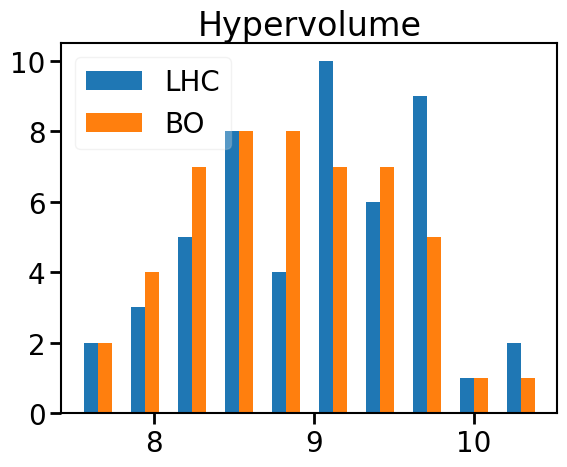

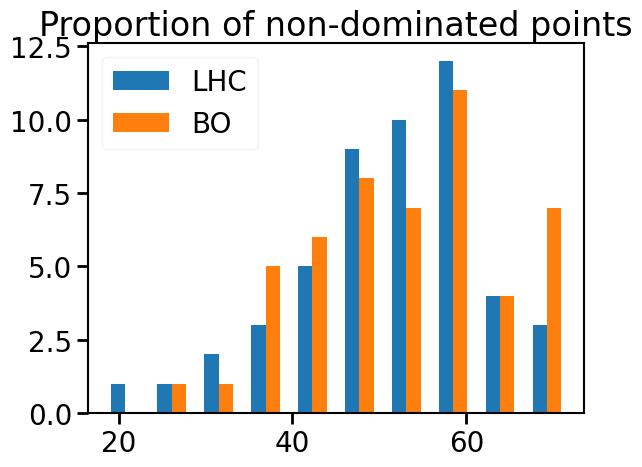

In [9]:
import matplotlib.pyplot as plt
plt.hist([np.log10(results[0,:,1]), np.log10(results[1,:,1])], label=['LHS', 'BO'], rwidth=0.6)
plt.legend(loc='upper left', framealpha=0.25)
plt.title("Log10(hypervolume)")
plt.show()

plt.hist([results[0,:,0], results[1,:,0]], label=['LHS', 'BO'], rwidth=0.6)
plt.legend(loc='upper left', framealpha=0.25)
plt.title("Proportion of points on Pareto front")
plt.show()

In [13]:
argument_pairs = [[50, 0], [20, 30]]
iterations = 100
results2 = np.empty(shape=[len(argument_pairs), iterations, 2])

for i in range(len(argument_pairs)):
    for j in range(iterations):
        fs, fh = run_experiment(argument_pairs[i][0], argument_pairs[i][1])
        results2[i, j] = [fs, fh]
        print(i, j)

Iter 10/100: 24.482868194580078
Iter 20/100: 20.7569522857666
Iter 30/100: 20.22614288330078
Iter 40/100: 19.75848388671875
Iter 50/100: 19.5206241607666
Iter 60/100: 19.46825408935547
Iter 70/100: 19.46350860595703
0 0
Iter 10/100: 24.456443786621094
Iter 20/100: 20.731935501098633
Iter 30/100: 20.19537353515625
Iter 40/100: 19.713285446166992
Iter 50/100: 19.477214813232422
Iter 60/100: 19.4263858795166
Iter 70/100: 19.421201705932617
0 1
Iter 10/100: 24.5094051361084
Iter 20/100: 20.77947998046875
Iter 30/100: 20.253538131713867
Iter 40/100: 19.80436134338379
Iter 50/100: 19.57147216796875
Iter 60/100: 19.5256404876709
Iter 70/100: 19.518692016601562
0 2
Iter 10/100: 24.46226692199707
Iter 20/100: 20.737163543701172
Iter 30/100: 20.203527450561523
Iter 40/100: 19.72178840637207
Iter 50/100: 19.481843948364258
Iter 60/100: 19.42459487915039
Iter 70/100: 19.42168617248535
0 3
Iter 10/100: 24.42780303955078
Iter 20/100: 20.69406509399414
Iter 30/100: 20.14725112915039
Iter 40/100: 19.6

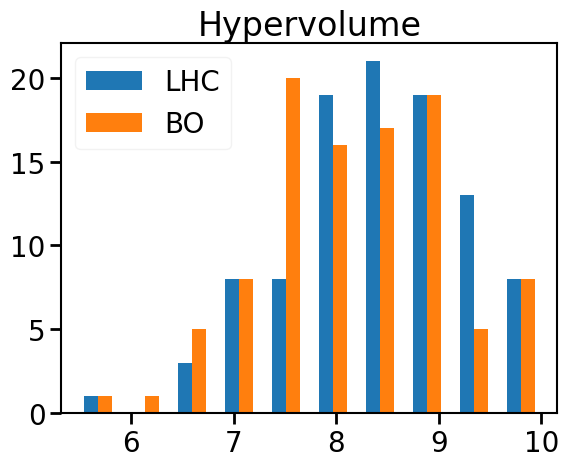

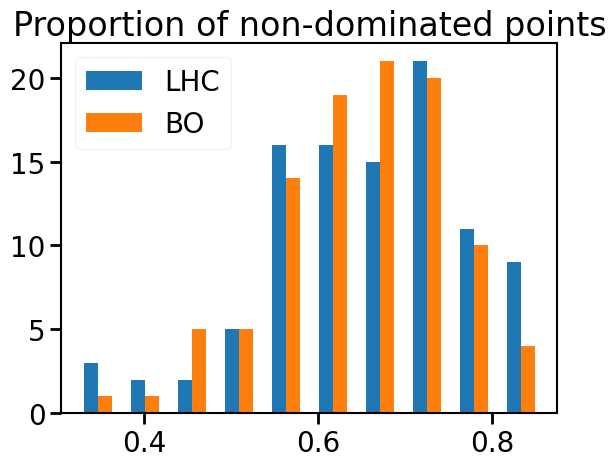

In [18]:
import matplotlib.pyplot as plt
plt.hist([np.log10(results2[0,:,1]), np.log10(results2[1,:,1])], label=['LHS', 'BO'], rwidth=0.6)
plt.legend(loc='upper left', framealpha=0.25)
plt.title("Log10(hypervolume)")
plt.show()

plt.hist([results2[0,:,0], results2[1,:,0]], label=['LHS', 'BO'], rwidth=0.6)
plt.legend(loc='upper left', framealpha=0.25)
plt.title("Proportion of points on Pareto front")
plt.show()

In [19]:
argument_pairs = [[75, 0], [25, 50]]
iterations = 200
results3 = np.empty(shape=[len(argument_pairs), iterations, 2])

for i in range(len(argument_pairs)):
    for j in range(iterations):
        fs, fh = run_experiment(argument_pairs[i][0], argument_pairs[i][1])
        results3[i, j] = [fs, fh]
        print(i, j)

Iter 10/100: 21.214921951293945
Iter 20/100: 18.69461441040039
Iter 30/100: 18.008699417114258
Iter 40/100: 17.137460708618164
Iter 50/100: 16.92706298828125
0 0
Iter 10/100: 21.235464096069336
Iter 20/100: 18.707767486572266
Iter 30/100: 18.024906158447266
Iter 40/100: 17.16153335571289
Iter 50/100: 16.94646644592285
0 1
Iter 10/100: 21.172840118408203
Iter 20/100: 18.633886337280273
Iter 30/100: 17.915184020996094
Iter 40/100: 16.937829971313477
Iter 50/100: 16.828725814819336
0 2
Iter 10/100: 21.25277328491211
Iter 20/100: 18.731245040893555
Iter 30/100: 18.059911727905273
Iter 40/100: 17.238014221191406
Iter 50/100: 16.999221801757812
Iter 60/100: 16.93709373474121
0 3
Iter 10/100: 21.254507064819336
Iter 20/100: 18.73446273803711
Iter 30/100: 18.063941955566406
Iter 40/100: 17.23757553100586
Iter 50/100: 17.00413703918457
0 4
Iter 10/100: 21.231542587280273
Iter 20/100: 18.698745727539062
Iter 30/100: 18.007680892944336
Iter 40/100: 17.113162994384766
Iter 50/100: 16.9490489959716

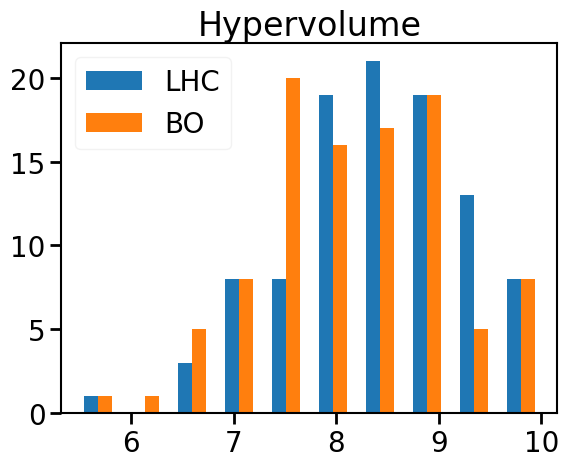

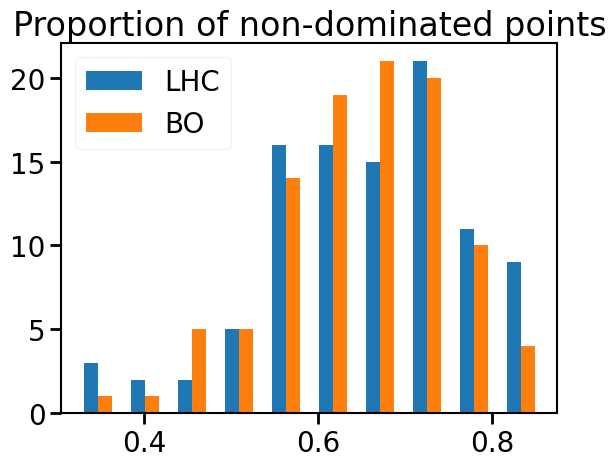

In [22]:
import matplotlib.pyplot as plt
plt.hist([np.log10(results3[0,:,1]), np.log10(results3[1,:,1])], label=['LHS', 'BO'], rwidth=0.6)
plt.legend(loc='upper left', framealpha=0.25)
plt.title("Log10(hypervolume)")
plt.show()

plt.hist([results3[0,:,0], results3[1,:,0]], label=['LHS', 'BO'], rwidth=0.6)
plt.legend(loc='upper left', framealpha=0.25)
plt.title("Proportion of points on Pareto front")
plt.show()

In [3]:
argument_pairs = [[200, 0], [100, 100]]
iterations = 100
results4 = np.empty(shape=[len(argument_pairs), iterations, 2])

for i in range(len(argument_pairs)):
    for j in range(iterations):
        fs, fh = run_experiment(argument_pairs[i][0], argument_pairs[i][1])
        results4[i, j] = [fs, fh]
        print(i, j)

/Users/jamessykes/Documents/Summer 2024/MO-BED Project/MO-BED Debugging/.venv/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:32: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1699.)
  L = torch.cholesky(A, upper=upper, out=out)
/Users/jamessykes/Documents/Summer 2024/MO-BED Project/MO-BED Debugging/.venv/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.s

Iter 10/100: 16.81217384338379
Iter 20/100: 15.344714164733887
Iter 30/100: 13.733670234680176
Iter 40/100: 10.516915321350098
0 0
Iter 10/100: 16.784713745117188
Iter 20/100: 15.316770553588867
Iter 30/100: 13.703471183776855
Iter 40/100: 10.551910400390625
0 1
Iter 10/100: 16.798751831054688
Iter 20/100: 15.318953514099121
Iter 30/100: 13.6769380569458
Iter 40/100: 10.474885940551758
0 2
Iter 10/100: 16.768400192260742
Iter 20/100: 15.293700218200684
Iter 30/100: 13.624223709106445
Iter 40/100: 10.29336929321289
0 3
Iter 10/100: 16.764543533325195
Iter 20/100: 15.28982162475586
Iter 30/100: 13.639693260192871
Iter 40/100: 10.430999755859375
0 4
Iter 10/100: 16.797082901000977
Iter 20/100: 15.327582359313965
Iter 30/100: 13.706859588623047
Iter 40/100: 10.549272537231445
0 5
Iter 10/100: 16.77198600769043
Iter 20/100: 15.301094055175781
Iter 30/100: 13.662227630615234
Iter 40/100: 10.44848918914795
0 6
Iter 10/100: 16.775165557861328
Iter 20/100: 15.309404373168945
Iter 30/100: 13.690

/Users/jamessykes/Documents/Summer 2024/MO-BED Project/MO-BED Debugging/.venv/lib/python3.8/site-packages/gpytorch/models/exact_prediction_strategies.py:233: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  Q, R = torch.qr(new_root.cpu())


Iter 10/100: 14.974544525146484
Iter 10/100: 15.03050708770752
Iter 10/100: 14.951150894165039
Iter 10/100: 14.893166542053223
Iter 10/100: 14.83388614654541
Iter 10/100: 14.74300765991211
Iter 10/100: 14.673336029052734
Iter 10/100: 14.609169006347656
Iter 10/100: 14.53471565246582
Iter 10/100: 14.558859825134277
Iter 10/100: 14.51485824584961
Iter 10/100: 14.463419914245605
Iter 10/100: 14.427160263061523
Iter 10/100: 14.36799430847168
Iter 10/100: 14.306750297546387
Iter 10/100: 14.257192611694336
Iter 10/100: 14.191682815551758
Iter 10/100: 14.15065860748291
Iter 10/100: 14.092517852783203
Iter 10/100: 14.027145385742188
20 trials completed
Iter 10/100: 13.976055145263672
Iter 10/100: 13.9263916015625
Iter 10/100: 13.881889343261719
Iter 10/100: 13.831815719604492
Iter 10/100: 13.771474838256836
Iter 10/100: 13.72471809387207
Iter 10/100: 13.700787544250488
Iter 10/100: 13.629384994506836
Iter 10/100: 13.583592414855957
Iter 10/100: 13.522062301635742
Iter 10/100: 13.47154426574707

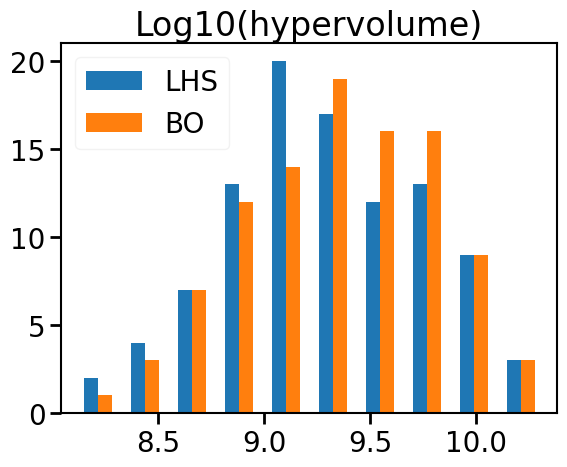

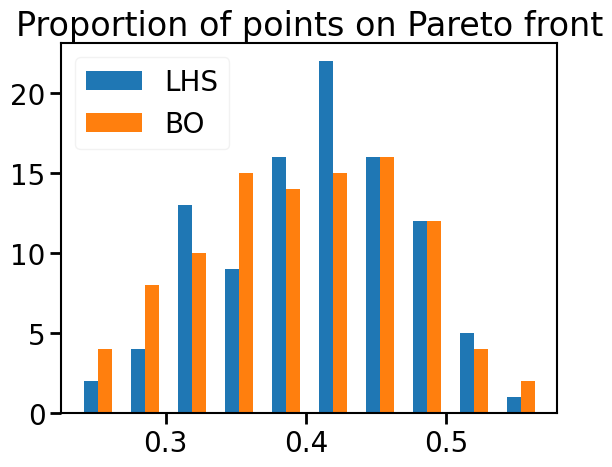

In [9]:
import matplotlib.pyplot as plt
plt.hist([np.log10(results4[0,:,1]), np.log10(results4[1,:,1])], label=['LHS', 'BO'], rwidth=0.6)
plt.legend(loc='upper left', framealpha=0.25)
plt.title("Log10(hypervolume)")
plt.show()

plt.hist([results4[0,:,0], results4[1,:,0]], label=['LHS', 'BO'], rwidth=0.6)
plt.legend(loc='upper left', framealpha=0.25)
plt.title("Proportion of points on Pareto front")
plt.show()